# Autoencoders

## 1 Setup

In [1]:
# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA

In [2]:
np.random.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [4]:
import tensorflow as tf
reset_graph()
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

In [5]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [6]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()

In [7]:
n_iterations = 10000
coding = hidden
with tf.Session() as sess:
    init.run()
    for interation in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = coding.eval(feed_dict={X: X_test})

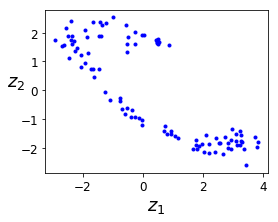

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

# Stacked Autoencoders

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/gaufung/WorkSpace/HMLST/data")

Extracting /Users/gaufung/WorkSpace/HMLST/data/train-images-idx3-ubyte.gz
Extracting /Users/gaufung/WorkSpace/HMLST/data/train-labels-idx1-ubyte.gz
Extracting /Users/gaufung/WorkSpace/HMLST/data/t10k-images-idx3-ubyte.gz
Extracting /Users/gaufung/WorkSpace/HMLST/data/t10k-labels-idx1-ubyte.gz


In [20]:
reset_graph()
from functools import partial
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # coding
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_partial = partial(tf.layers.dense,
                           activation=tf.nn.elu,
                           kernel_initializer=he_init,
                           kernel_regularizer=l2_regularizer)
hidden1 = my_dense_partial(X, n_hidden1)
hidden2 = my_dense_partial(hidden1, n_hidden2)
hidden3 = my_dense_partial(hidden2, n_hidden3)
outputs = my_dense_partial(hidden3, n_outputs, activation=None)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)

training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")    

0 Train MSE: 0.0223695
1 Train MSE: 0.011576
2 Train MSE: 0.0104548
3 Train MSE: 0.0101719
4 Train MSE: 0.0098028


In [22]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

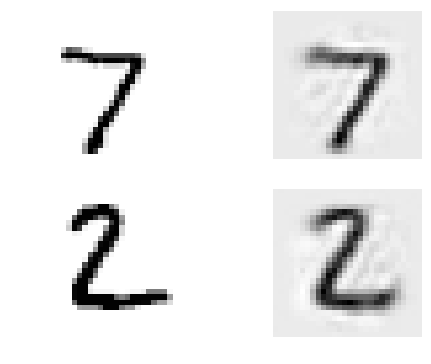

In [25]:
show_reconstructed_digits(X, outputs, "/Users/gaufung/WorkSpace/HMLST/Chapter14/my_model_all_layers.ckpt")
#save_fig("reconstruction_plot")

# Tying Weights

In [26]:
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [29]:
activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initilizer = tf.contrib.layers.variance_scaling_initializer()
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [30]:
weight1_init = initilizer([n_inputs, n_hidden1])
weight2_init = initilizer([n_hidden1, n_hidden2])

weight1 = tf.Variable(weight1_init, dtype=tf.float32, name='weights1')
weight2 = tf.Variable(weight2_init, dtype=tf.float32, name='weights2')
weight3 = tf.transpose(weight2, name='weight3')
weight4 = tf.transpose(weight1, name='weight4')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weight1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weight2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weight3) + biases3)
outputs = tf.matmul(hidden3, weight4) + biases4

In [32]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
reg_loss = regularizer(weight1) + regularizer(weight2)
loss = reconstruction_loss + reg_loss

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [34]:
saver = tf.train.Saver()

In [35]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0295439
1 Train MSE: 0.026863
2 Train MSE: 0.0264512
3 Train MSE: 0.0254662
4 Train MSE: 0.0257643


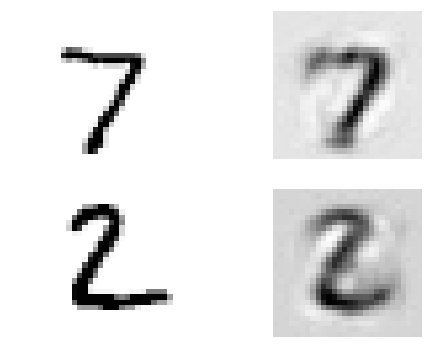

In [36]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

# Training one Autoencoder at a time in a single graph

In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00768351
1 Train MSE: 0.00764861
2 Train MSE: 0.00722312
3 Train MSE: 0.0075902
Training phase #2
0 Train MSE: 0.146254
1 Train MSE: 0.0039927
2 Train MSE: 0.00240416
3 Train MSE: 0.00192417
Test MSE: 0.00967345


# Unsupervised pretraining

In [41]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [43]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.933333 Test accuracy: 0.9275
1 Train accuracy: 0.966667 Test accuracy: 0.9351
2 Train accuracy: 0.96 Test accuracy: 0.9378
3 Train accuracy: 0.973333 Test accuracy: 0.946


In [46]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "/Users/gaufung/WorkSpace/HMLST/Chapter14/my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "/Users/gaufung/WorkSpace/HMLST/Chapter14/my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /Users/gaufung/WorkSpace/HMLST/Chapter14/my_model_cache_frozen.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]

Caused by op 'save/RestoreV2_2', defined at:
  File "/Users/gaufung/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gaufung/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-3ffe31a5a1ab>", line 44, in <module>
    pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/gaufung/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /Users/gaufung/WorkSpace/HMLST/Chapter14/my_model_cache_frozen.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]


# Stacked denoising Autoencoder

In [47]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [48]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [49]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [50]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.043547
1 Train MSE: 0.0402932
2 Train MSE: 0.0396382
3 Train MSE: 0.0407563
4 Train MSE: 0.0417976
5 Train MSE: 0.0417086
6 Train MSE: 0.0409972
7 Train MSE: 0.0399496
8 Train MSE: 0.0425804
9 Train MSE: 0.0407985


using dropout

In [51]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [52]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.0302302
1 Train MSE: 0.0253113
2 Train MSE: 0.0262474
3 Train MSE: 0.0242105
4 Train MSE: 0.0251463
5 Train MSE: 0.0237205
6 Train MSE: 0.0237524
7 Train MSE: 0.0243243
8 Train MSE: 0.0239038
9 Train MSE: 0.0244547


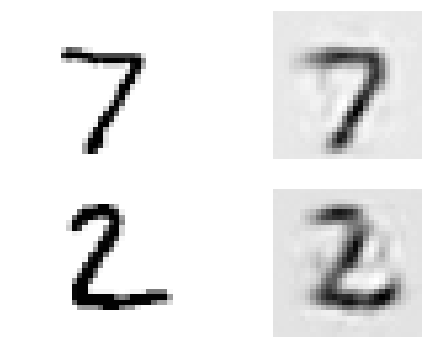

In [55]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# Sparsity Autoecoder

[0, 1, 0, 0.95]

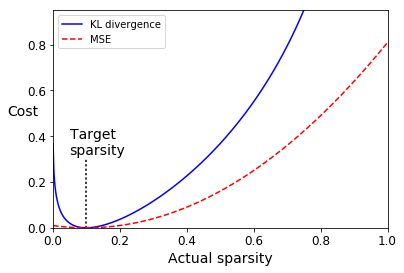

In [57]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [58]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [59]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [61]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.144076 	Sparsity loss: 0.234456 	Total loss: 0.190968
1 Train MSE: 0.0593777 	Sparsity loss: 0.0577239 	Total loss: 0.0709225
2 Train MSE: 0.0548157 	Sparsity loss: 0.512933 	Total loss: 0.157402
3 Train MSE: 0.047433 	Sparsity loss: 0.165889 	Total loss: 0.0806108
4 Train MSE: 0.0452981 	Sparsity loss: 0.0980072 	Total loss: 0.0648996
5 Train MSE: 0.0426474 	Sparsity loss: 0.00652927 	Total loss: 0.0439533
6 Train MSE: 0.0383659 	Sparsity loss: 0.0302544 	Total loss: 0.0444168
7 Train MSE: 0.0370433 	Sparsity loss: 0.0898655 	Total loss: 0.0550164
8 Train MSE: 0.0334308 	Sparsity loss: 0.00908268 	Total loss: 0.0352474
9 Train MSE: 0.0307176 	Sparsity loss: 0.0515204 	Total loss: 0.0410216
10 Train MSE: 0.0269975 	Sparsity loss: 0.0332162 	Total loss: 0.0336408
11 Train MSE: 0.0260866 	Sparsity loss: 0.0629221 	Total loss: 0.038671
12 Train MSE: 0.0227729 	Sparsity loss: 0.0194418 	Total loss: 0.0266612
13 Train MSE: 0.0230543 	Sparsity loss: 0.13289 	Total loss: 0.0496

# Variational Autoencoders

In [66]:
reset_graph()
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [67]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [68]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [69]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 28949.9 	Reconstruction loss: 23631.7 	Latent loss: 5318.24
1 %Train total loss: 31652.6 	Reconstruction loss: 24392.0 	Latent loss: 7260.57
2 Train total loss: 27235.0 	Reconstruction loss: 22252.4 	Latent loss: 4982.65
3 Train total loss: 35664.0 	Reconstruction loss: 25252.0 	Latent loss: 10411.9
4 Train total loss: 26609.6 	Reconstruction loss: 21993.5 	Latent loss: 4616.1
5 Train total loss: 23205.2 	Reconstruction loss: 19582.4 	Latent loss: 3622.81
6 Train total loss: 22222.5 	Reconstruction loss: 18369.0 	Latent loss: 3853.48
7 Train total loss: 18038.1 	Reconstruction loss: 15232.3 	Latent loss: 2805.73
8 Train total loss: 17937.2 	Reconstruction loss: 14985.7 	Latent loss: 2951.46
9 Train total loss: 16827.5 	Reconstruction loss: 13706.0 	Latent loss: 3121.53
10 Train total loss: 16512.6 	Reconstruction loss: 13349.4 	Latent loss: 3163.21
11 Train total loss: 16412.5 	Reconstruction loss: 13275.7 	Latent loss: 3136.87
12 Train total loss: 17132.7 	Reconstr

In [70]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Generate digits

In [71]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 17589.5 	Reconstruction loss: 14010.7 	Latent loss: 3578.77
1 Train total loss: 17353.0 	Reconstruction loss: 13550.7 	Latent loss: 3802.26
2 Train total loss: 16728.6 	Reconstruction loss: 12912.6 	Latent loss: 3815.94
3 Train total loss: 16237.6 	Reconstruction loss: 12557.7 	Latent loss: 3679.87
4 Train total loss: 16152.0 	Reconstruction loss: 12370.3 	Latent loss: 3781.77
5 Train total loss: 15452.6 	Reconstruction loss: 11781.0 	Latent loss: 3671.6
6 Train total loss: 15825.8 	Reconstruction loss: 11970.0 	Latent loss: 3855.86
7 Train total loss: 15685.3 	Reconstruction loss: 11911.3 	Latent loss: 3774.01
8 Train total loss: 16019.8 	Reconstruction loss: 12160.5 	Latent loss: 3859.31
9 Train total loss: 15800.7 	Reconstruction loss: 11993.2 	Latent loss: 3807.5
10 Train total loss: 15815.2 	Reconstruction loss: 11974.1 	Latent loss: 3841.09
11 Train total loss: 15550.7 	Reconstruction loss: 11815.1 	Latent loss: 3735.62
12 Train total loss: 15709.0 	Reconstruc

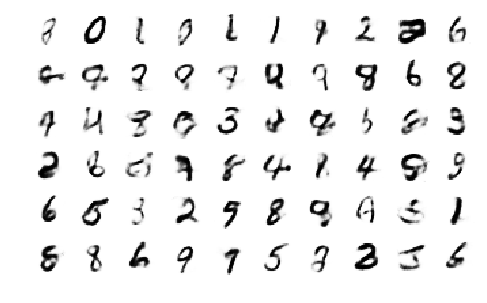

In [72]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

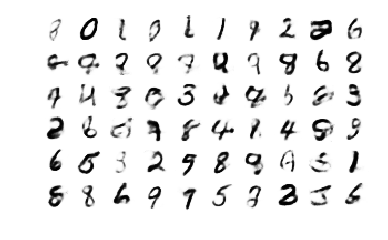

In [74]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()